# Part 3: Train a RetinaNet to Detect ElectroMagnetic Signals

**Author:** [lukewood](https://lukewood.xyz), Kevin Anderson, Peter Gerstoft<br>
**Date created:** 2022/08/16<br>
**Last modified:** 2022/08/16<br>
**Description:** Train ...

In [1]:
%load_ext autoreload
%autoreload 2

## Overview

With the learnings from part 2, lets take our newly tuned AnchorGenerator and fit another RetinaNet.
First, we will do all of the same setup that we did in the first tutorial.

In [2]:
import sys
import functools
import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import flags
from keras_cv import bounding_box
from tensorflow import keras
from tensorflow.keras import callbacks as callbacks_lib
from tensorflow.keras import optimizers
from luketils import artifacts
import em_loader
import wandb
from luketils import visualization
import os

batch_size = 8
epochs = 1

ground_truth_mapping = [
    "Ground Truth",
]
ground_truth_mapping = dict(zip(range(len(ground_truth_mapping)), ground_truth_mapping))

prediction_mapping = [
    "Prediction",
]
prediction_mapping = dict(zip(range(len(prediction_mapping)), prediction_mapping))

In [3]:
checkpoint_path = 'weights/'

In [4]:
artifacts_dir = 'artifacts/tuned'
artifacts.set_base(artifacts_dir)
os.makedirs(artifacts_dir, exist_ok=True)

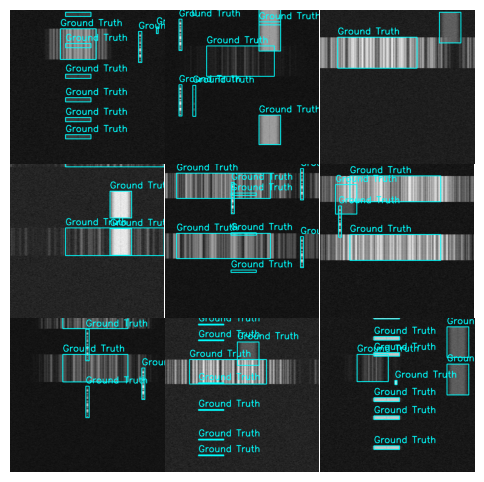

In [5]:
dataset, dataset_info = em_loader.load(
    split="train",
    bounding_box_format="xywh",
    batch_size=9,
    version=2,
)


example = next(iter(dataset))
images, boxes = example["images"], example["bounding_boxes"]
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format="xywh",
    y_true=boxes,
    scale=2,
    rows=3,
    cols=3,
    thickness=2,
    font_scale=1,
    class_mapping=ground_truth_mapping,
    path=f"{artifacts_dir}/ground-truth.png",
)
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format="xywh",
    y_true=boxes,
    scale=2,
    rows=3,
    cols=3,
    thickness=2,
    font_scale=1,
    class_mapping=ground_truth_mapping,
    show=True,
)

Same as before, nothing to see here.

In [6]:
# train_ds is batched as a (images, bounding_boxes) tuple
# bounding_boxes are ragged
train_ds, train_dataset_info = em_loader.load(
    bounding_box_format="xywh", split="train", batch_size=batch_size, version=2
)
val_ds, val_dataset_info = em_loader.load(
    bounding_box_format="xywh", split="val", batch_size=batch_size, version=2
)


def unpackage_dict(inputs):
    return inputs["images"], inputs["bounding_boxes"]

train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Our data pipeline is now complete.  We can now move on to model creation and training.

## Model creation

We'll use the KerasCV API to construct a RetinaNet model.  In this tutorial we use
a pretrained ResNet50 backbone using weights.  In order to perform fine-tuning, we
freeze the backbone before training.  When `include_rescaling=True` is set, inputs to
the model are expected to be in the range `[0, 255]`.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers


class PredictionHead(layers.Layer):
    """The class/box predictions head.

    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_initializer: Bias Initializer for the final convolution layer.

    Returns:
      A function representing either the classification
        or the box regression head depending on `output_filters`.
    """

    def __init__(self, output_filters, bias_initializer, num_conv_layers=3, **kwargs):
        super().__init__(**kwargs)
        self.output_filters = output_filters
        self.bias_initializer = bias_initializer
        self.num_conv_layers = num_conv_layers

        self.conv_layers = [
            layers.Conv2D(
                256,
                kernel_size=3,
                padding="same",
                kernel_initializer=tf.keras.initializers.Orthogonal(),
                activation="relu",
            )
            for _ in range(num_conv_layers)
        ]
        self.prediction_layer = layers.Conv2D(
            self.output_filters,
            kernel_size=3,
            strides=1,
            padding="same",
            kernel_initializer=tf.keras.initializers.Orthogonal(),
            bias_initializer=self.bias_initializer,
        )

    def call(self, x, training=False):
        for layer in self.conv_layers:
            x = layer(x, training=training)
        x = self.prediction_layer(x, training=training)
        return x

    def get_config(self):
        config = {
            "bias_initializer": self.bias_initializer,
            "output_filters": self.output_filters,
            "num_conv_layers": self.num_conv_layers,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [8]:
strides = [2**i for i in range(3, 8)]
scales = [2**x for x in [0, 1 / 4, 1 / 2]]
sizes = [32.0, 64.0, 128.0, 256.0, 512.0]
aspect_ratios=[0.098923504, 0.37597612, 0.8440275, 1.9752489, 3.036192, 9.539244]
anchor_generator = keras_cv.layers.AnchorGenerator(
    bounding_box_format='xywh',
    sizes=sizes,
    aspect_ratios=aspect_ratios,
    scales=scales,
    strides=strides,
    clip_boxes=True,
)

In [9]:
import numpy as np
prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
classification_head = PredictionHead(
    output_filters=18 * 1, bias_initializer=prior_probability
)
box_head = PredictionHead(
    output_filters=18 * 4, bias_initializer="zeros"
)

In [10]:
model = keras_cv.models.RetinaNet(
    classes=1,
    anchor_generator=anchor_generator,
    bounding_box_format="xywh",
    backbone="resnet50",
    backbone_weights="imagenet",
    classification_head = classification_head,
    box_head = box_head,
    include_rescaling=True,
    evaluate_train_time_metrics=False,
)

In [11]:
optimizer = tf.optimizers.SGD(global_clipnorm=10.0)
metrics = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        class_ids=range(1),
        bounding_box_format="xywh",
        name="MaP",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(1),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall",
    ),
]

model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=metrics,
)

All that is left to do is construct some callbacks:

In [12]:
callbacks = [
    callbacks_lib.TensorBoard(log_dir="logs"),
    callbacks_lib.ReduceLROnPlateau(patience=7),
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True),
]

And run `model.fit()`!

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds.take(20),
    epochs=50,
    callbacks=callbacks,
)

Epoch 1/50
483/483 [==============================] - 98s 174ms/step - loss: 3.8385 - classification_loss: 1.5621 - regularization_loss: 0.0000e+00 - box_loss: 2.2764 - val_MaP: 0.2172 - val_Recall: 0.3633 - val_loss: 2.1175 - val_classification_loss: 0.7678 - val_box_loss: 1.3497 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 2/50
483/483 [==============================] - 77s 159ms/step - loss: 1.3197 - classification_loss: 0.4276 - regularization_loss: 0.0000e+00 - box_loss: 0.8921 - val_MaP: 0.3035 - val_Recall: 0.4352 - val_loss: 1.0558 - val_classification_loss: 0.3515 - val_box_loss: 0.7043 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 3/50
483/483 [==============================] - 76s 156ms/step - loss: 0.8133 - classification_loss: 0.2188 - regularization_loss: 0.0000e+00 - box_loss: 0.5944 - val_MaP: 0.3286 - val_Recall: 0.4331 - val_loss: 0.8675 - val_classification_loss: 0.3186 - val_box_loss: 0.5489 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
E

# Model Evaluation

In [32]:
metrics = history.history

In [33]:
', '.join(metrics.keys())

'loss, classification_loss, regularization_loss, box_loss, val_MaP, val_Recall, val_loss, val_classification_loss, val_box_loss, val_regularization_loss, lr'

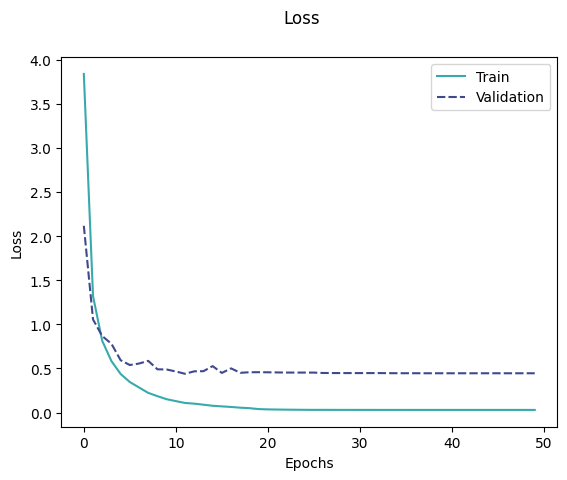

In [34]:
metrics_to_plot = {
    'Train': metrics['loss'],
    'Validation': metrics['val_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Loss', xlabel='Epochs', ylabel='Loss', transparent=True)
plot_fn(path=f'{artifacts_dir}/loss.png')
plot_fn(show=True)

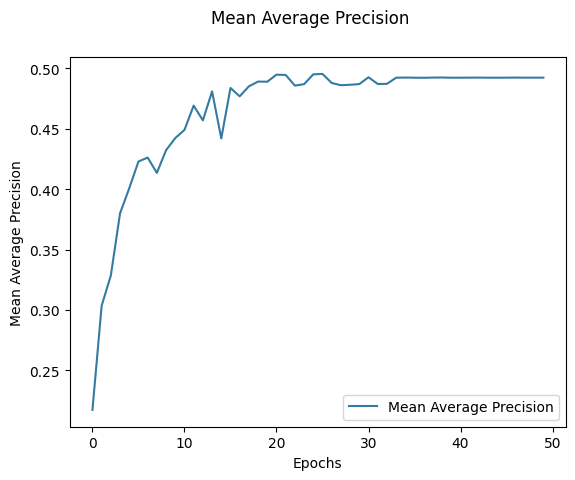

In [35]:
metrics_to_plot = {
    'Mean Average Precision': metrics['val_MaP'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Mean Average Precision', xlabel='Epochs', ylabel='Mean Average Precision')
plot_fn(path=f'{artifacts_dir}/MaP.png')
plot_fn(show=True)


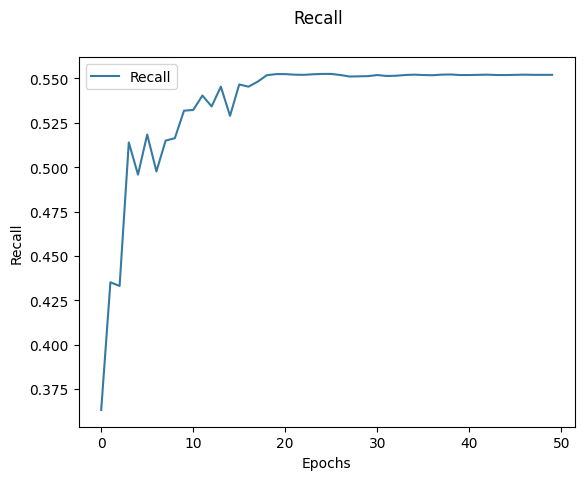

In [36]:
metrics_to_plot = {
    'Recall': metrics['val_Recall'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Recall', xlabel='Epochs', ylabel='Recall')
plot_fn(path=f'{artifacts_dir}/Recall.png')
plot_fn(show=True)

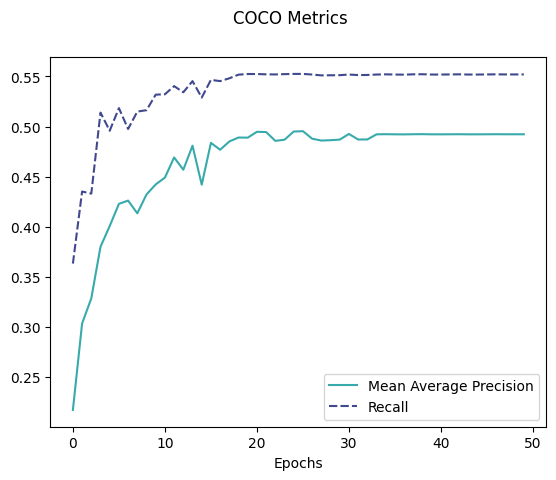

In [37]:
metrics_to_plot = {
    'Mean Average Precision': metrics['val_MaP'],
    'Recall': metrics['val_Recall'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='COCO Metrics', xlabel='Epochs')
plot_fn(path=f'{artifacts_dir}/COCO_Metrics.png')
plot_fn(show=True)

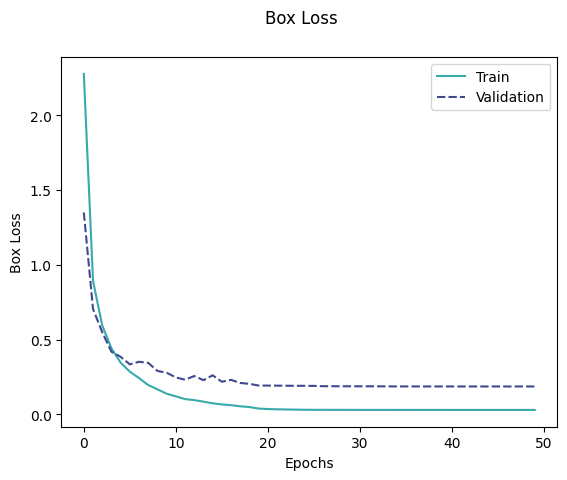

In [38]:
metrics_to_plot = {
    'Train': metrics['box_loss'],
    'Validation': metrics['val_box_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Box Loss', xlabel='Epochs', ylabel='Box Loss')
plot_fn(path=f'{artifacts_dir}/box_loss.png')
plot_fn(show=True)

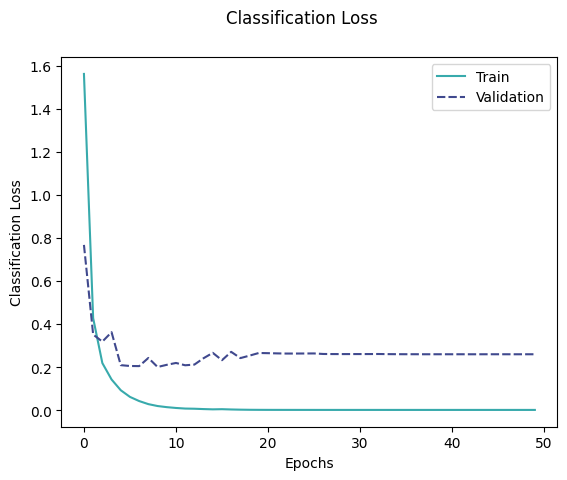

In [39]:
metrics_to_plot = {
    'Train': metrics['classification_loss'],
    'Validation': metrics['val_classification_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Classification Loss', xlabel='Epochs', ylabel='Classification Loss')
plot_fn(path=f'{artifacts_dir}/classification_loss.png')
plot_fn(show=True)

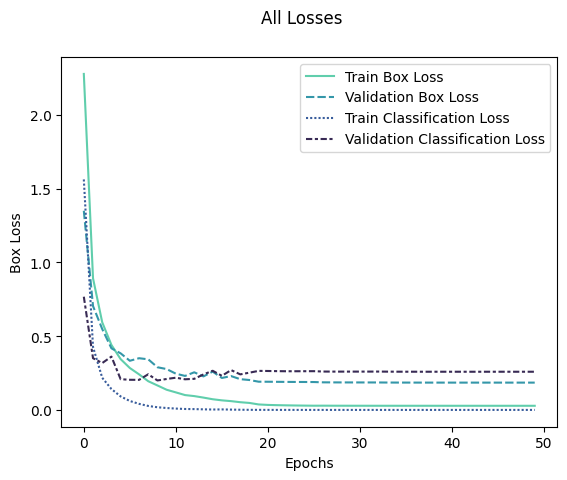

In [40]:
metrics_to_plot = {
    'Train Box Loss': metrics['box_loss'],
    'Validation Box Loss': metrics['val_box_loss'],
    'Train Classification Loss': metrics['classification_loss'],
    'Validation Classification Loss': metrics['val_classification_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='All Losses', xlabel='Epochs', ylabel='Box Loss')
plot_fn(path=f'{artifacts_dir}/all_losses.png')
plot_fn(show=True)

In [41]:
model.load_weights(checkpoint_path)

In [42]:
final_metrics = model.evaluate(val_ds, return_dict=True)

104/104 [==============================] - 107s 1s/step - MaP: 0.4922 - Recall: 0.5647 - loss: 0.4913 - classification_loss: 0.2753 - box_loss: 0.2160 - regularization_loss: 0.0000e+00


In [43]:
print("FINAL METRICS:", metrics)

FINAL METRICS: {'MaP': 0.4922463297843933, 'Recall': 0.5647461414337158, 'loss': 0.49125343561172485, 'classification_loss': 0.2752969563007355, 'box_loss': 0.21595636010169983, 'regularization_loss': 0.0}


In [44]:
os.makedirs(f'{artifacts_dir}/metrics/', exist_ok=True)
for metric in final_metrics:
    with open(f"{artifacts_dir}/metrics/{metric}.txt", "w") as f:
        f.write(str(round(final_metrics[metric], 3)))

In [45]:
import functools

def visualize_detections(model, split="train"):
    train_ds, val_dataset_info = em_loader.load(
        bounding_box_format="xywh", split=split, batch_size=9
    )
    train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
    images, y_true = next(iter(train_ds.take(1)))
    y_pred = model.predict(images)
    
    plot_fn = functools.partial(
        visualization.plot_bounding_box_gallery,
        images,
        value_range=(0, 255),
        bounding_box_format='xywh',
        y_true=y_true,
        y_pred=y_pred,
        scale=2,
        rows=3,
        cols=3,
        thickness=2,
        font_scale=1,
        legend=True,
    )
    plot_fn(
        show=True,
    )
    plot_fn(
        path=f"{artifacts_dir}/{split}.png"
    )
    

1/1 [==============================] - 0s 71ms/step


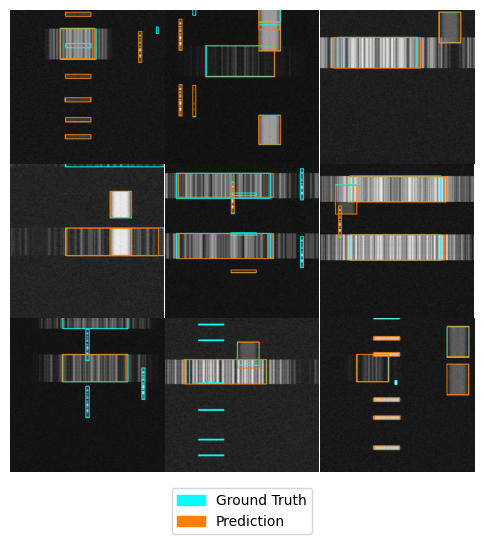

In [51]:
visualize_detections(model, split="train")

1/1 [==============================] - 0s 71ms/step


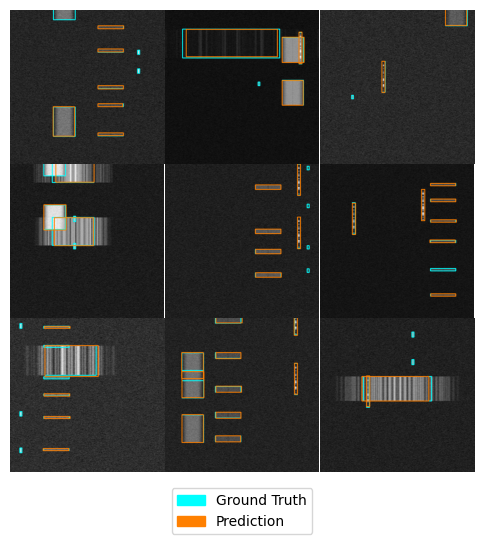

In [48]:
visualize_detections(model, split="val")

# Conclusion

With proper anchor configuration we are able to achieve both strong MaP and Recall metrics.  Both converge around `0.5~`, which is quite strong.  For perspective, the state of the art on PascalVOC is around `0.45~`. 

In future works, we can consider exploring data augmentation, anchor free models, and more.